<h1>Final Project</h1>
<h3>Battle of the Neiborhoods</h3>

<h2>Import Libraries</h2>

<h4>Numerous libraries will be needed to parse the data.  All are imported here at the beginning of the project.</h4>

In [2]:
import pandas as pd 
import numpy as np 
from pandas.io.json import json_normalize


from IPython.display import Image 
from IPython.core.display import HTML 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 
!conda install -c conda-forge folium=0.5.0 --yes
import folium 

import requests 
import types
from botocore.client import Config
import ibm_boto3

import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

   

<h2>Foursquare Credentials</h2>
<h4>These are required to pull the venue information.</h4>
<h4>The credentials have been removed in this shared version.</h4>

In [3]:
# The code was removed by Watson Studio for sharing.

<h2>IBM Cloud Credentials</h2>
<h4>These are required to import the initial data in .csv format.</h4>
<h4>The credentials have been removed in this shared version.</h4>

In [4]:
# The code was removed by Watson Studio for sharing.

<h4>This is the actual import the base institution data from the .csv file</h4>

In [5]:
# The code was removed by Watson Studio for sharing.

,Institution,Division,Location,State,Enrollment
0,Indiana University,East,Bloomington,Indiana,48514.0
1,University of Maryland,East,College Park,Maryland,38140.0
2,University of Michigan,East,Ann Arbor,Michigan,43625.0
3,Michigan State University,East,East Lansing,Michigan,50085.0
4,Ohio State University,East,Columbus,Ohio,58322.0


<h4>Create a list without the Univesity of Minnesota.<br>
    This data will also contain the fields that will be populated in future data gathering.</h4>

In [31]:
MySchool = pd.DataFrame(columns=['Institution','school','Division','State','Enrollment','latitude','longitude','Asian','Mexican','C_Score'])
MySchool['Institution'] = universities['Institution']
MySchool['school'] = universities['Institution'] + " - " + universities['Location']
MySchool['Division'] = universities['Division']
MySchool['State'] = universities['State']
MySchool['Enrollment'] = universities['Enrollment']
MySchool.head(4)

,Institution,school,Division,State,Enrollment,latitude,longitude,Asian,Mexican,C_Score
0,Indiana University,Indiana University - Bloomington,East,Indiana,48514.0,NaN,NaN,NaN,NaN,NaN
1,University of Maryland,University of Maryland - College Park,East,Maryland,38140.0,NaN,NaN,NaN,NaN,NaN
2,University of Michigan,University of Michigan - Ann Arbor,East,Michigan,43625.0,NaN,NaN,NaN,NaN,NaN
3,Michigan State University,Michigan State University - East Lansing,East,Michigan,50085.0,NaN,NaN,NaN,NaN,NaN


<h4> Add the location data (latitude an longitude) for the institutions</h4>

In [32]:
for eachU in MySchool['school']:
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(eachU)
    latitude = location.latitude
    longitude = location.longitude
    
    MySchool.loc[MySchool['school'] == eachU, ['latitude']] = latitude
    MySchool.loc[MySchool['school'] == eachU, ['longitude']] = longitude

MySchool.head(4)
    

,Institution,school,Division,State,Enrollment,latitude,longitude,Asian,Mexican,C_Score
0,Indiana University,Indiana University - Bloomington,East,Indiana,48514.0,39.1772,-86.5154,NaN,NaN,NaN
1,University of Maryland,University of Maryland - College Park,East,Maryland,38140.0,38.992,-76.9461,NaN,NaN,NaN
2,University of Michigan,University of Michigan - Ann Arbor,East,Michigan,43625.0,42.2942,-83.71,NaN,NaN,NaN
3,Michigan State University,Michigan State University - East Lansing,East,Michigan,50085.0,42.7186,-84.4779,NaN,NaN,NaN


<h4> Add the counts of the Asian style restaurants</h4>

In [33]:
#Create the URL list
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
URL_List = MySchool.drop(['school', 'Division','State','Enrollment','Asian','Mexican','C_Score'], axis=1)
URL_List['search_query'] = 'Asian'
URL_List['radius'] = 10000
URL_List['LIMIT'] = 100

#Set the parameters for the URL query
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
search_query = 'Asian'
radius = 10000
LIMIT = 100

# define the function that extracts the category of the venue
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
  

In [34]:
#This is the actual update section
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
mycount = 0
for everyone in URL_List['latitude']:
    #print(URL_List.loc[mycount,'latitude'],URL_List.loc[mycount,'longitude'],URL_List.loc[mycount,'search_query'],URL_List.loc[mycount,'radius'], URL_List.loc[mycount,'LIMIT'])
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET,URL_List.loc[mycount,'latitude'], URL_List.loc[mycount,'longitude'], VERSION, URL_List.loc[mycount,'search_query'], URL_List.loc[mycount,'radius'], URL_List.loc[mycount,'LIMIT'])

    results = requests.get(url).json()
    venues = results['response']['venues']

    dataframe = json_normalize(venues)
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
    Asian = len(dataframe_filtered.index)
    MySchool.loc[MySchool['latitude'] == URL_List.loc[mycount,'latitude'], ['Asian']] = Asian
    #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    mycount = mycount + 1


<h4> Add the counts of the Mexican style restaurants</h4>
<i> This section is obviously not efficient.  However, for the 
purposes of this project, the section was repeated completely<br> 
in order to verify the counts and score calulation</i>

In [35]:
#Create the URL list
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
URL_List = MySchool.drop(['school', 'Division','State','Enrollment','Asian','Mexican','C_Score'], axis=1)
URL_List['search_query'] = 'Mexican'
URL_List['radius'] = 10000
URL_List['LIMIT'] = 100

#Set the parameters for the URL query
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
search_query = 'Mexican'
radius = 10000
LIMIT = 100

In [36]:
#This is the actual update section
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
mycount = 0
for everyone in URL_List['latitude']:
    #print(URL_List.loc[mycount,'latitude'],URL_List.loc[mycount,'longitude'],URL_List.loc[mycount,'search_query'],URL_List.loc[mycount,'radius'], URL_List.loc[mycount,'LIMIT'])
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET,URL_List.loc[mycount,'latitude'], URL_List.loc[mycount,'longitude'], VERSION, URL_List.loc[mycount,'search_query'], URL_List.loc[mycount,'radius'], URL_List.loc[mycount,'LIMIT'])

    results = requests.get(url).json()
    venues = results['response']['venues']

    dataframe = json_normalize(venues)
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
    Mexican = len(dataframe_filtered.index)
    MySchool.loc[MySchool['latitude'] == URL_List.loc[mycount,'latitude'], ['Mexican']] = Mexican
    #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    mycount = mycount + 1

In [37]:
MySchool.head(4)

,Institution,school,Division,State,Enrollment,latitude,longitude,Asian,Mexican,C_Score
0,Indiana University,Indiana University - Bloomington,East,Indiana,48514.0,39.1772,-86.5154,2,9,NaN
1,University of Maryland,University of Maryland - College Park,East,Maryland,38140.0,38.992,-76.9461,39,44,NaN
2,University of Michigan,University of Michigan - Ann Arbor,East,Michigan,43625.0,42.2942,-83.71,9,20,NaN
3,Michigan State University,Michigan State University - East Lansing,East,Michigan,50085.0,42.7186,-84.4779,10,23,NaN


<h4>Visually confirm with a map the Mexican counts that were found in the last download</h4><br>
<i>As a sanity check, map one school and then chart all of the counts across schools</i>

In [38]:
map_confirmation = folium.Map(location=[latitude, longitude], zoom_start=13)

# add a red circle marker to represent the University
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='University',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_confirmation)

# add the Asian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(map_confirmation)
       
map_confirmation

<h4>Visually confirm the counts that were found</h4>

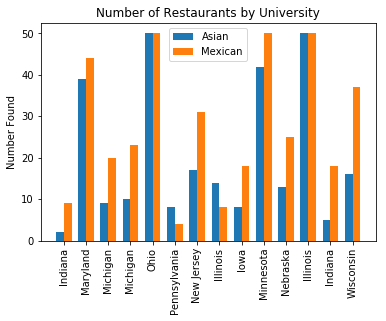

In [39]:
ind = np.arange(len(MySchool['school'])) 
width = 0.35       
plt.bar(ind, MySchool['Asian'], width, label='Asian')
plt.bar(ind + width, MySchool['Mexican'], width, label='Mexican')

plt.ylabel('Number Found')
plt.title('Number of Restaurants by University')

plt.xticks(ind + width / 2, MySchool['State'])
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.show()

<h2>Calculate and rank the Concentration Score</h2>

In [40]:
for ischool in MySchool['latitude']:
    MySchool['C_Score'] = ((MySchool['Enrollment'] / 10000) / (1 / MySchool['Asian'])) + ((MySchool['Enrollment'] / 10000) / (1 / MySchool['Mexican']))

#Don't forget to remove Minnesota
MySchool = MySchool[MySchool.State != "Minnesota"]

<h1>The Final Results Table:</h1>

In [41]:
MySchool.sort_values(by='C_Score', ascending=False)

,Institution,school,Division,State,Enrollment,latitude,longitude,Asian,Mexican,C_Score
4,Ohio State University,Ohio State University - Columbus,East,Ohio,58322.0,40.0057,-83.0287,50,50,583.2200
1,University of Maryland,University of Maryland - College Park,East,Maryland,38140.0,38.992,-76.9461,39,44,316.5620
13,University of Wisconsin,University of Wisconsin - Madison,West,Wisconsin,49193.0,43.0798,-89.4307,16,37,260.7229
11,Northwestern University,Northwestern University - Evanston,West,Illinois,21208.0,42.0551,-87.6758,50,50,212.0800
6,Rutgers University,Rutgers University - New Brunswick,East,New Jersey,40720.0,40.4791,-74.4317,17,31,195.4560
3,Michigan State University,Michigan State University - East Lansing,East,Michigan,50085.0,42.7186,-84.4779,10,23,165.2805
2,University of Michigan,University of Michigan - Ann Arbor,East,Michigan,43625.0,42.2942,-83.71,9,20,126.5125
10,University of Nebraska,University of Nebraska - Lincoln,West,Nebraska,33273.0,40.8175,-96.7045,13,25,126.4374
7,University of Illinois,University of Illinois - Champaign-Urbana,West,Illinois,49339.0,40.1007,-88.2313,14,8,108.5458
12,Purdue University,Purdue University - West Lafayette,West,Indiana,39464.0,40.4275,-86.9123,5,18,90.7672


<h4> The highest scoring university:</h4>

In [42]:
MySchool[MySchool['C_Score']==MySchool['C_Score'].max()]

,Institution,school,Division,State,Enrollment,latitude,longitude,Asian,Mexican,C_Score
4,Ohio State University,Ohio State University - Columbus,East,Ohio,58322.0,40.0057,-83.0287,50,50,583.22
